In [1]:
import re
import warnings
import os
import folium
import geopandas as gpd
import pandas as pd
import numpy as np
import statsmodels as sm
import seaborn as sns 
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import scipy.stats as stats 

from scipy.stats import powerlaw 
from folium import plugins
from folium.plugins import HeatMap
from IPython.display import IFrame

from violation_preprocessing import violation_separator, violations_dataframe

%matplotlib inline
sns.set()
warnings.filterwarnings('ignore')

In [106]:
# import the cleaning dataset 
data = pd.read_csv('data/clean_dataset.csv', delimiter = ',')

# drop the unnamed column
data.drop(['Unnamed: 0'], axis = 1,inplace = True)

# convert the zip column into an str
data.zip = data.zip.astype(str)
    
# reformat the zip code writing in order to compare it with the zip code in geojson file (for vizualisation step)
data['zip'] = data['zip'].apply(lambda x : x.split('.')[0])

# show the dataframe
display(data.head(3))

,inspection_id,dba_name,aka_name,license,facility_type,risk,address,zip,inspection_date,inspection_type,results,violations,latitude,longitude,location
0,2346127,CREPE HOUSE CAFE,CREPE HOUSE CAFE,2637127.0,Restaurant,Risk 1 (High),5033 N ELSTON AVE,60630,2019-11-22,Canvass Re-Inspection,Pass,NaN,41.972349,-87.746825,"{'latitude': '-87.74682508578468', 'longitude'..."
1,2346126,LEANS NUTRITION CLUB,LEANS NUTRITION CLUB,2432147.0,Restaurant,Risk 2 (Medium),5302 S PULASKI RD,60632,2019-11-22,Canvass Re-Inspection,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.796699,-87.723408,"{'latitude': '-87.72340756196249', 'longitude'..."
2,2346149,PINKS CHILD CARE ACADEMY II,PINK'S CHILD CARE ACADEMY II,2215652.0,Daycare Combo 1586,Risk 1 (High),8000 S KEDZIE AVE,60652,2019-11-22,Canvass,Fail,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.747934,-87.702489,"{'latitude': '-87.70248876124471', 'longitude'..."


**This notebook is decomposed in 3 parts :**
- **PART I :** *map plotting for spatial exploration of the given parameters. Also, we introduced new parameters as sanitation complaints and e-coli concentration in Chicago beaches based on emitted hypothesis.*
- **PART II :** *comparison between the violations comitted during inspections due to suspected food poisoning and other type of inspections.*
- **PART III:** *application of machine learning models in order to try predecting relevant parameters that can help us creating a score for assessing food safety in later steps.*

# PART I : Spatial exploration of the data

> In this part, we explore the data by mapping. We want to investigate if there are relevant differences between Chicago areas.

## Mapping functions

In [4]:
# function that generate basic maps 
def generateBaseMap(default_location = [41.8600, -87.6298], default_zoom_start = 10):
    '''
    generates a map for the corect area
    
    Parameters
    ----------
    default_location: list of floats
        location of where the map is going to be
    
    default_zoom_start: int
        the amount of zoom on the map in beginning
    
    '''
    base_map = folium.Map(location=default_location, control_scale = True, zoom_start = default_zoom_start)
    return base_map

In [117]:
def geodataframe(df):
    '''
    converts a dataframe into a geodataframe
    
    Parameters
    ----------
    df: pandas.dataframe
    
    Returns
    -------
    gdf: geopandas.dataframe
    '''

    # path to geoJson file 
    geo = os.path.join('data/Boundaries-ZIPCodes.geojson')

    # creation of a geodataframe using geopandas
    gdf = gpd.read_file(geo)

    # add a column with the x-coordinate of the multipolygon
    gdf['centroid_lon'] = gdf['geometry'].centroid.x

    # add a column with the y-coordinate of the multipolygon
    gdf['centroid_lat'] = gdf['geometry'].centroid.y

    # setting a projection  by assigning the WGS84 latitude-longitude CRS to the crs attribute
    gdf.crs = {'init' :'epsg:4326'}
    
    # counting the number of facilities per zip 
    facility_number_per_zip = pd.DataFrame(df.groupby('zip')['license'].count()).reset_index()
    
    if (type(df.zip) is not str):
        # convert the zip column into an str
        facility_number_per_zip.zip = facility_number_per_zip.zip.astype(str)
    
        # reformat the zip code writing in order to compare it with the zip code in geojson file (for vizualisation step)
        facility_number_per_zip['zip'] = facility_number_per_zip['zip'].apply(lambda x : x.split('.')[0])
    
    # merge with the geodataframe
    gdf = pd.merge(gdf,facility_number_per_zip, on = 'zip')
    gdf.rename(columns = {'license': 'facility_number_per_zip'}, inplace = True)
    
    return gdf
    

In [118]:
# creating our geodataframe based on the basic dataframe
gdf = geodataframe(data)
gdf.head(3)

,objectid,shape_area,shape_len,zip,geometry,centroid_lon,centroid_lat,facility_number_per_zip
0,33,106052287.488,42720.0444058,60647,"MULTIPOLYGON (((-87.67762 41.91776, -87.67761 ...",-87.702259,41.921098,4605
1,34,127476050.762,48103.7827213,60639,"MULTIPOLYGON (((-87.72683 41.92265, -87.72693 ...",-87.755996,41.920456,3433
2,35,45069038.4783,27288.6096123,60707,"MULTIPOLYGON (((-87.78500 41.90915, -87.78531 ...",-87.795738,41.919948,738


In [119]:
def chlorepleth_map (name,gdf,columns,legend_name,color):
    '''
    mapping cloropleth map
    
    Parameters
    ----------
    name: str 
        name of map
    
    gdf: geopandas.dataframe
        dataframe with data for mapping
    
    columns: list
        columns with data for mapping
    
    legend_name: str
        name on scale 
    
    color: str
        color scheme for map
        
    Returns
    -------
    map_: folium.folium.Map
    '''

    #creating a basic map of Chicago
    map_ = folium.Map(location=[41.8600, -87.6298], control_scale=True, zoom_start=10)
    
    #geoJson file path
    geo = os.path.join('data/Boundaries-ZIPCodes.geojson')
    
    folium.Choropleth(
        geo_data=geo,
        name='name',
        data=gdf,
        columns=columns,
        key_on='feature.properties.zip',
        fill_color=color,
        fill_opacity=0.8,
        line_opacity=1,
        legend_name=legend_name
    ).add_to(map_)
    
    #if (markers==True):
        #add_markers(map)
    
    return map_

    

## 1- Area with the highest number of inspection 

> It is important to see if there is a homogeneous inspection repartition in Chicago. Let's check if there are areas with higher inspection counts than others.

In [5]:
# mapping the areas with the highest number of inspections 
data['count'] = 1
base_map = generateBaseMap()
HeatMap(data = data[['latitude', 'longitude', 'count']].groupby(['latitude', 'longitude']).sum().reset_index().values.tolist(), radius=8, max_zoom=13).add_to(base_map)
#base_map.save('base_map.html')
IFrame(src = 'maps/base_map.html', width = 700, height = 600)

**Obsersations:** we can observe that the areas in the Chicago periphery are less inspected. This is coherent with what we expected since there are more facilities in a city center and also near the sea.

## 2-  Proportion of failed inspection per zip area

> The aim of this part is to see if there is a correlation between the localization of the facilities and the results of the inspection. Here, we focus on the facilities that failed the inspection. 

In [9]:
# creating a dataset with only the fail results 
fail_data = data[~data['results'].isin(['Pass','Pass w/ Conditions'])]

# counting the number of fail per zip code
fail_count_per_zip = pd.DataFrame(fail_data.groupby('zip')['results'].count()).reset_index()
fail_count_per_zip.rename(columns = {'results': 'fail_count'}, inplace = True)

As we saw in the heat map above, some areas are more inspected that others. Thus, we need to calculate a proportion of fails per zip code ( not an absolute count since it will be influenced by the facilities count in a particular area).

In [10]:
# merge with gdf dataframe and facility count dataframe 
fail_gdf = pd.merge(fail_count_per_zip,gdf, on = 'zip')

# proportion of facility that failed the investigation per zip code
fail_gdf['fail_proportion'] = fail_gdf['fail_count'].divide(fail_gdf['facility_number_per_zip'])
fail_gdf.head(3)

,zip,fail_count,objectid,shape_area,shape_len,geometry,centroid_lon,centroid_lat,facility_number_per_zip,fail_proportion
0,60601,310,27,9166245.79985,19804.5821088,"MULTIPOLYGON (((-87.62271 41.88884, -87.62232 ...",-87.621022,41.886404,2509,0.123555
1,60602,154,26,4847124.8171,14448.1749926,"MULTIPOLYGON (((-87.60997 41.88436, -87.60997 ...",-87.623661,41.883318,1098,0.140255
2,60603,199,19,4560228.98203,13672.6822885,"MULTIPOLYGON (((-87.61633 41.88211, -87.61635 ...",-87.624471,41.880647,1407,0.141436


In [11]:
fail_map = chlorepleth_map('Fail proportion',fail_gdf,['zip','fail_proportion'],'Fail proportion','YlOrRd')
#fail_map.save('fail_map.html')
IFrame(src = 'maps/fail_map.html', width = 700, height = 600)

**Obervations:** We can observe that some zip code areas have a higher number of failed inspections than others. We can notice a high number of failed in the middle south of Chicago. 

## 3- Mapping the proportion of pass and pass w/conditions

In [12]:
# creating a dataset with only the pass and pass w/conditions results 
pass_data = data[~data['results'].isin(['Fail'])]

# counting the number of pass inspections per zip code
pass_count_per_zip = pd.DataFrame(pass_data.groupby('zip')['results'].count()).reset_index()
pass_count_per_zip.rename(columns = {'results': 'pass_count'}, inplace = True)

In [13]:
# merge with gdf dataframe and facility count dataframe 
pass_gdf = pd.merge(pass_count_per_zip,gdf, on = 'zip')

# proportion of facility that passed the investigation per zip code
pass_gdf['pass_proportion'] = pass_gdf['pass_count'].divide(pass_gdf['facility_number_per_zip'])
pass_gdf.head(3)

,zip,pass_count,objectid,shape_area,shape_len,geometry,centroid_lon,centroid_lat,facility_number_per_zip,pass_proportion
0,60601,2199,27,9166245.79985,19804.5821088,"MULTIPOLYGON (((-87.62271 41.88884, -87.62232 ...",-87.621022,41.886404,2509,0.876445
1,60602,944,26,4847124.8171,14448.1749926,"MULTIPOLYGON (((-87.60997 41.88436, -87.60997 ...",-87.623661,41.883318,1098,0.859745
2,60603,1208,19,4560228.98203,13672.6822885,"MULTIPOLYGON (((-87.61633 41.88211, -87.61635 ...",-87.624471,41.880647,1407,0.858564


In [14]:
pass_map = chlorepleth_map('Pass proportion',pass_gdf,['zip','pass_proportion'],'Pass proportion','YlGn')
#pass_map.save('pass_map.html')
IFrame(src = 'maps/pass_map.html', width = 700, height = 600)

**Obervations**: This map leads to the same conclusion than the one above , as expected.

## 4- Proportion of poisoning complain in a given zip area

In [15]:
# creating a dataset with only the inspections due to poisoning
poisoning_data = data[data['inspection_type'] == 'Suspected Food Poisoning']

# counting the number of fail per zip code
poisoning_count_per_zip = pd.DataFrame(poisoning_data.groupby('zip')['results'].count()).reset_index()
poisoning_count_per_zip.rename(columns = {'results': 'poisoning_inpections_count'}, inplace = True)

In [16]:
# merge with gdf dataframe and facility count dataframe 
poisoning_gdf = pd.merge(poisoning_count_per_zip,gdf, on = 'zip')

# proportion of facility that passed the investigation per zip code
poisoning_gdf['poisoning_proportion'] = poisoning_gdf['poisoning_inpections_count'].divide(poisoning_gdf['facility_number_per_zip'])
pass_gdf.head(3)

,zip,pass_count,objectid,shape_area,shape_len,geometry,centroid_lon,centroid_lat,facility_number_per_zip,pass_proportion
0,60601,2199,27,9166245.79985,19804.5821088,"MULTIPOLYGON (((-87.62271 41.88884, -87.62232 ...",-87.621022,41.886404,2509,0.876445
1,60602,944,26,4847124.8171,14448.1749926,"MULTIPOLYGON (((-87.60997 41.88436, -87.60997 ...",-87.623661,41.883318,1098,0.859745
2,60603,1208,19,4560228.98203,13672.6822885,"MULTIPOLYGON (((-87.61633 41.88211, -87.61635 ...",-87.624471,41.880647,1407,0.858564


In [17]:
poisoning_map = chlorepleth_map ('Poisoning proportion',poisoning_gdf,['zip','poisoning_proportion'],'Suspected poisoning proportion','RdPu')
#poisoning_map.save('poisoning_map.html')
IFrame(src = 'maps/poisoning_map.html', width = 700, height = 600)

**Observations** : We can observe that some areas had a higher number of inspections due to suspected food poisoning. These areas do not seem to necessary correlate with the pass/fail results of inspections. Also, it seems that we have a high concentration of this kind of investigation in the center of Chicago near to the sea. We need to investigate more about that.
> It seems like the area where there are the more inspections due to supsected food poisoning are near the sea. We  need to investigate more about this because of the presence of e-coli in sea water. Does it play a role in this complain about food poisoning ? To do so, we will study later a dataframe which provide predictions about e-coli concentration at beaches in Chicago.

## 5- Is there a link with Chicago Sanitation Violations ? 

**Hypothesis** : The areas with the higher number of sanitation complaints will have more chance to fail the inspection/ give food poisoning.

In [120]:
# import the cleaning dataset 
sanitation_df = pd.read_csv('data/sanitation.csv', delimiter = ',')
sanitation_df.head(5)

,Creation Date,Status,Completion Date,Service Request Number,Type of Service Request,What is the Nature of this Code Violation?,Street Address,ZIP Code,X Coordinate,Y Coordinate,Ward,Police District,Community Area,Latitude,Longitude,Location
0,08/01/2017,Completed - Dup,08/04/2017,17-05101063,Sanitation Code Violation,Garbage in alley,3016 W MONTROSE AVE,60618.0,1.155406e+06,1.929085e+06,33.0,17.0,14.0,41.961215,-87.704035,"(41.961215172275, -87.704034715236)"
1,05/31/2017,Completed,08/04/2017,17-03559234,Sanitation Code Violation,Other,3359 W 19TH ST,60623.0,1.154205e+06,1.890509e+06,24.0,10.0,29.0,41.855383,-87.709482,"(41.855383440674, -87.709481507782)"
2,07/14/2017,Completed,08/04/2017,17-04636140,Sanitation Code Violation,Garbage in alley,7212 S 73RD ST ER,60619.0,1.182810e+06,1.857288e+06,8.0,3.0,69.0,41.763603,-87.605521,"(41.763602787373, -87.605520591847)"
3,07/09/2017,Completed,08/04/2017,17-04526947,Sanitation Code Violation,Other,3418 W GRENSHAW ST,60624.0,1.153756e+06,1.894848e+06,24.0,11.0,29.0,41.867299,-87.711014,"(41.867298732126, -87.711014045253)"
4,08/03/2017,Completed,08/04/2017,17-05156088,Sanitation Code Violation,NaN,2659 N MASON AVE,60639.0,1.136274e+06,1.917063e+06,30.0,25.0,19.0,41.928589,-87.774662,"(41.928588854849, -87.774662171276)"


In [121]:
# counting number of sanitation complaints per zip code area
sanitation_df_per_zip = sanitation_df.groupby('ZIP Code')['Service Request Number'].count()
sanitation_df_per_zip = pd.DataFrame(sanitation_df_per_zip)
sanitation_df_per_zip.reset_index(inplace = True)
sanitation_df_per_zip.rename(columns = {'Service Request Number': 'Sanitation Violation count','ZIP Code':'zip'}, inplace=True)

sanitation_df_per_zip.head(5)

,zip,Sanitation Violation count
0,0.0,2
1,60601.0,196
2,60602.0,169
3,60603.0,75
4,60604.0,59


In [122]:
# creation of a geodataframe

# path to geoJson file 
geo = os.path.join('data/Boundaries-ZIPCodes.geojson')

# creation of a geodataframe using geopandas
gdf_sanitation = gpd.read_file(geo)

# add a column with the x-coordinate of the multipolygon
gdf_sanitation['centroid_lon'] = gdf_sanitation['geometry'].centroid.x

# add a column with the y-coordinate of the multipolygon
gdf_sanitation['centroid_lat'] = gdf_sanitation['geometry'].centroid.y

# setting a projection  by assigning the WGS84 latitude-longitude CRS to the crs attribute
gdf_sanitation.crs = {'init' :'epsg:4326'}
    
# convert the zip column into an str
sanitation_df_per_zip.zip = sanitation_df_per_zip.zip.astype(str)
    
# reformat the zip code writing in order to compare it with the zip code in geojson file (for vizualisation step)
sanitation_df_per_zip['zip'] = sanitation_df_per_zip['zip'].apply(lambda x : x.split('.')[0])
    
# merge with the geodataframe
gdf_sanitation = pd.merge(gdf,sanitation_df_per_zip,on='zip')

gdf_sanitation.head(5)    

,objectid,shape_area,shape_len,zip,geometry,centroid_lon,centroid_lat,facility_number_per_zip,Sanitation Violation count
0,33,106052287.488,42720.0444058,60647,"MULTIPOLYGON (((-87.67762 41.91776, -87.67761 ...",-87.702259,41.921098,4605,5888
1,34,127476050.762,48103.7827213,60639,"MULTIPOLYGON (((-87.72683 41.92265, -87.72693 ...",-87.755996,41.920456,3433,4281
2,35,45069038.4783,27288.6096123,60707,"MULTIPOLYGON (((-87.78500 41.90915, -87.78531 ...",-87.795738,41.919948,738,715
3,51,3450671.14336,7909.89040711,60707,"MULTIPOLYGON (((-87.80662 41.93451, -87.80686 ...",-87.811606,41.936196,738,715
4,36,70853834.3797,42527.9896789,60622,"MULTIPOLYGON (((-87.66707 41.88885, -87.66707 ...",-87.684212,41.903126,4251,3563


In [123]:
sanitation_map = chlorepleth_map('Sanitation violation',gdf_sanitation,['zip','Sanitation Violation count'],'Sanitation Violation Count','BuPu')
#sanitation_map.save('sanitation_map.html')
IFrame(src = 'maps/sanitation_map.html', width = 700, height = 600)

**Observations**: We can observe sanitation problems in south Chicago. But, it seems that there is no correlation between those sanitations problem and the poisoning. 

> We will investigate this further during milestone 3 (correlation between the number of fails and the sanitation comaplaints). 

## 6- E. Coli Prevention in Chicago Beach Waters

Escherichia coli is a bacterium that lives in the intestines of humans and animals alike and also causes food poisoning illness. A major source of E. coli infections is undercooked beef. Other sources of E. coli bacteria include drinking or swimming in water that is contaminated by sewage. E. coli bacterium, which is present in stool, can be passed from person-to-person as a result of improper hygiene or handwashing practices.

People can become infected when a contaminated city or town water supply has not been properly treated with chlorine or when people accidentally swallow contaminated water while swimming in a lake, pool, or irrigation canal.
The bacteria can also spread from one person to another, usually when an infected person does not wash his or her hands well after a bowel movement. E. coli can spread from an infected person's hands to other people or to objects.

> The Chicago Park District issues swim advisories at beaches along Chicago's Lake Michigan lakefront based on E. coli levels. The dataset below shows predicted E. coli levels based on an experimental analytical modeling approach.

In [18]:
ecoli_df = pd.read_csv('data/beach-e.-coli-predictions.csv',delimiter = ',')

> US Environmental Protection Agency (USEPA) recommends notifying the public when E. coli bacteria levels are above the federal water quality Beach Action Value (BAV), which is 235*CFU. Thus, we will keep only the predicted values that are above this limit.

In [19]:
data_filtered = ecoli_df[ecoli_df['Predicted Level'] > 235]

In [20]:
high_ecoli_concentration = pd.DataFrame(data_filtered.groupby('Beach Name')['Predicted Level'].count())
high_ecoli_concentration.reset_index(inplace = True)
high_ecoli_concentration

,Beach Name,Predicted Level
0,12th Street,47
1,57th Street,9
2,Foster,49
3,Hartigan (Albion),4
4,Howard,5
5,Juneway,9
6,Leone,9
7,Margaret T Burroughs (31st),72
8,Marion Mahony Griffin (Jarvis),9
9,North Avenue,7


In [21]:
# merging the data_filtered dataframe with the high_ecoli_concentration dataframe to have beaches' location
high_ecoli_concentration_location = pd.merge(data_filtered,high_ecoli_concentration,on = 'Beach Name', how = 'inner')

# groupby beaches and creating a dataframe
high_ecoli_concentration_location = high_ecoli_concentration_location.groupby('Beach Name').first()

high_ecoli_concentration_location = pd.DataFrame(high_ecoli_concentration_location)
high_ecoli_concentration_location.rename(columns = {'Predicted Level_y': 'High measure count'}, inplace=True)
high_ecoli_concentration_location.reset_index(inplace = True)
high_ecoli_concentration_location.sort_values(by=['High measure count'], ascending = False)

high_ecoli_concentration_location.head(3)

,Beach Name,Date,Prediction Source,Predicted Level_x,RecordID,Latitude,Longitude,Location,High measure count
0,12th Street,2017-06-05T00:00:00,DNA Model,240.8,12thStreet20170605,41.8638,-87.6082,"{'needs_recoding': False, 'longitude': '-87.60...",47
1,57th Street,2017-07-20T00:00:00,DNA Model,312.6,57thStreet20170720,41.7911,-87.5797,"{'needs_recoding': False, 'longitude': '-87.57...",9
2,Foster,2017-05-26T00:00:00,DNA Model,334.7,Foster20170526,41.9785,-87.6515,"{'needs_recoding': False, 'longitude': '-87.65...",49


In [22]:
# create a map using the Map() function and the coordinates for Chicago
m = folium.Map(location=[41.8600, -87.6298], zoom_start = 12)

def Adding_Marker(map_, longitude, latitude, popup, colour):
    '''
    adds a marker which locates a facility on the map
    
    map_: folium.folium.Map
        basic map
    
    longitude: numpy.float64
    
    latitude: numpy.float64
    
    popup: str
        beach name and count of e-coli consentration higher than limit
    
    colour: str
    '''
    folium.Marker(
        location = [latitude,longitude], # coordinates for the marker 
        popup = popup ,  # pop-up label for the marker
        icon = folium.Icon(color = colour)
    ).add_to(map_)

for i in range(len(high_ecoli_concentration_location)):
    popup = str(high_ecoli_concentration_location['Beach Name'].values[i]) + '\n'+'#High measure count :'+ str(high_ecoli_concentration_location['High measure count'].values[i])
    if (high_ecoli_concentration_location['High measure count'].values[i]  < 10):
        colour = 'blue'
    if (high_ecoli_concentration_location['High measure count'].values[i] < 30 and high_ecoli_concentration_location['High measure count'].values[i]>10 ):
        colour = 'orange'
    if (high_ecoli_concentration_location['High measure count'].values[i] >= 30):
        colour = 'red'
    Adding_Marker(m,high_ecoli_concentration_location.Longitude.values[i], high_ecoli_concentration_location.Latitude.values[i], popup , colour)

#m.save('ecoli_map.html')
IFrame(src = 'maps/ecoli_map.html', width = 700, height = 600)

**Observations** :  We observe that we have a high e-coli sea water concentration in some beaches in Chicago. What is interesting to notice, is the 12th Street beach which is located at Chicago center and correlate with a high number of inspection due to suspected food poisoning. We need to investigate this fact in order to understand how this both parameter could be linked.
> We can try to overlap this map with the one above.

In [23]:
for i in range(len(high_ecoli_concentration_location)):
    popup = str(high_ecoli_concentration_location['Beach Name'].values[i]) + '\n'+'High measure count :'+ str(high_ecoli_concentration_location['High measure count'].values[i])
    if (high_ecoli_concentration_location['High measure count'].values[i]  < 10):
        colour = 'blue'
    if (high_ecoli_concentration_location['High measure count'].values[i] <30 and high_ecoli_concentration_location['High measure count'].values[i]>10 ):
        colour = 'orange'
    if (high_ecoli_concentration_location['High measure count'].values[i] >= 30):
        colour = 'red'
    Adding_Marker(poisoning_map,high_ecoli_concentration_location.Longitude.values[i], high_ecoli_concentration_location.Latitude.values[i], popup , colour)

    
#poisoning_map.save('ecoli_wpoisoning.html')
IFrame(src = 'maps/ecoli_wpoisoning.html', width = 700, height = 600)

**Observations** : When we overlap this data, we observe that in most cases the high concentration of e-coli is correlated with a higher of inspection due to food poisoning.

### Part I conclusions 

We can observe that some areas have moer failed inspections than others. In South Chicago, we can notice a sanitation problem but also a higher number of fails. About food poisoning, it seems like the majority of inspections due to food poisoning are located in the Chicago seaside. We can emit the hypothesis that this correlates with the e-coli concentration predicted in the extra data-set we used.

**Future Work :**
- Add markers in order to identify the zip code number of each area
- explain the sanitation results ( cf South Chicago )
- try to find a statistical correlation between the e-coli concentration and the high number of inspection due to food poisoning. Find a consistent explanation . 


# PART II : What are the most frequent violations noticed during inspections due to food poisoning ? 

>The aim of this part is to investigate if particular violations can be releveant to predict food poisoning. Each violation is characterized by a number from 1 to 44 (+70) . Based on the official Chicago [Violation code](https://webapps1.chicago.gov/healthinspection/Code_Violations.jsp), we categorize them.

## Violation characterization 


  > First, we would like to use the information that are in the *violation* column. For that, we need to clean it and make it more readable.

In [30]:
# we apply functions from file violation_preprocessing.py to our basic data 
violation_separated = data.violations.apply(violation_separator).fillna(0)

In [45]:
# we create our dataframe with all the violations counts
violations_df,violations_dataframe = violations_dataframe(violation_separated,data)

In [48]:
print('\n\033[1m Violations per inspection (binary value representation) \033[0m')
display(violations_df.head(3))

print('\n\033[1m Number of critical ,serious and minor count per inspection \033[0m')
display(violations_dataframe.head(3))



 Violations per inspection (binary value representation) 


,#1,#2,#3,#4,#5,#6,#7,#8,#9,#10,...,#42,#43,#44,#70,inspection_id,license,inspection_type,zip,risk,results
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2346127,2637127.0,Canvass Re-Inspection,60630,Risk 1 (High),Pass
1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2346126,2432147.0,Canvass Re-Inspection,60632,Risk 2 (Medium),Pass w/ Conditions
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,2346149,2215652.0,Canvass,60652,Risk 1 (High),Fail



 Number of critical ,serious and minor count per inspection 


,inspection_id,dba_name,aka_name,license,facility_type,risk,address,zip,inspection_date,inspection_type,results,violations,latitude,longitude,location,count,critical_count,serious_count,minor_count,violations_count
0,2346127,CREPE HOUSE CAFE,CREPE HOUSE CAFE,2637127.0,Restaurant,Risk 1 (High),5033 N ELSTON AVE,60630,2019-11-22,Canvass Re-Inspection,Pass,0,41.972349,-87.746825,"{'latitude': '-87.74682508578468', 'longitude'...",1,0.000000,0.0,0.000000,0.0
1,2346126,LEANS NUTRITION CLUB,LEANS NUTRITION CLUB,2432147.0,Restaurant,Risk 2 (Medium),5302 S PULASKI RD,60632,2019-11-22,Canvass Re-Inspection,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.796699,-87.723408,"{'latitude': '-87.72340756196249', 'longitude'...",1,1.000000,0.0,0.000000,2.0
2,2346149,PINKS CHILD CARE ACADEMY II,PINK'S CHILD CARE ACADEMY II,2215652.0,Daycare Combo 1586,Risk 1 (High),8000 S KEDZIE AVE,60652,2019-11-22,Canvass,Fail,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.747934,-87.702489,"{'latitude': '-87.70248876124471', 'longitude'...",1,0.666667,0.0,0.333333,3.0


## Case 1 : inspection due to suspected food poisoning 

In [44]:
#selecting only the inspection due to suspected food poisoning
food_poisoning_df = violations_df.loc[violations_dataframe['inspection_type'] == 'Suspected Food Poisoning']

food_poisoning_df.head(3)

,#1,#2,#3,#4,#5,#6,#7,#8,#9,#10,...,#42,#43,#44,#70,inspection_id,license,inspection_type,zip,risk,results
125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,2345759,2511920.0,Suspected Food Poisoning,60657,Risk 1 (High),Pass w/ Conditions
293,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2321008,2647777.0,Suspected Food Poisoning,60638,Risk 1 (High),Pass
827,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2315831,37212.0,Suspected Food Poisoning,60642,Risk 1 (High),Pass


> We created a csv file in order to assign a violation name to each number : [violations_description](https://github.com/marisofie/epfl_ada_project/blob/master/data/liste_colonnes.csv)

In [54]:
# import violation titles
titles = pd.read_csv("data/liste_colonnes.csv", delimiter = ';')
food_poisoning_df.rename(columns = titles.iloc[0], inplace = True)

In [60]:
# sum binary values for each violation
sums = food_poisoning_df.drop(["inspection_id","license",'inspection_type','zip','risk','results'], axis = 1).sum()

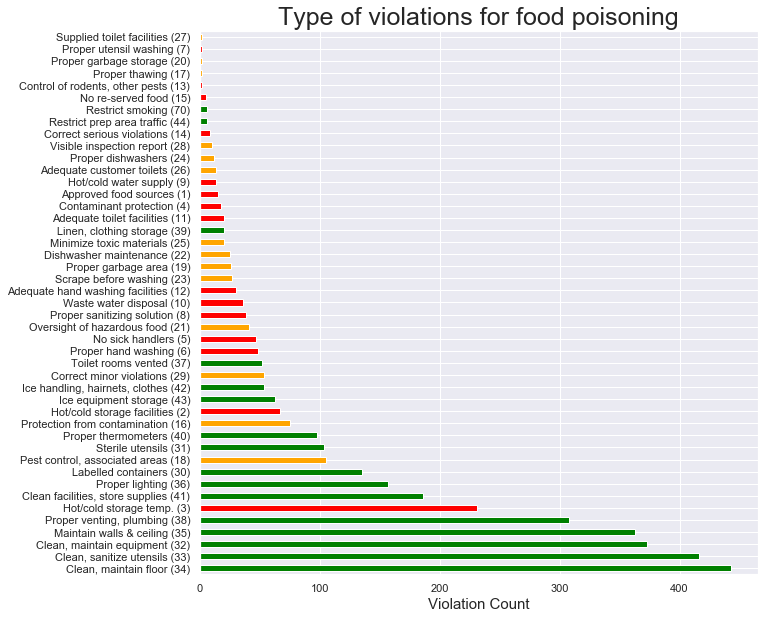

In [61]:
# generate color list
colors = ["red"]*15  + ["orange"]*14  + ["green"]*16 

# sort sums and colors by sum value
sum_data = pd.DataFrame({"sums": sums, "colors": colors}).sort_values("sums")

# plot bar chart
plt.rcParams['figure.figsize'] = (10, 10)
ax = sum_data.sums.plot(kind = "barh", color = sum_data.colors)
ax.set_title("Type of violations for food poisoning", fontsize = 25)
ax.set_xlabel("Violation Count", fontsize = 15)
ax.invert_yaxis()
plt.show()

**Observations**: 
- Critical factors that seems to cause food poisoning : *hot/cold storage temp/facilities* and *hand washing*.
- Serious factors that seems to cause food poisoning : *pest control* and *protection from contamination*

In order to draw a more consistant conclusion, we need to compare this result with other inspections type.

> We need to calculate the frequency of each violation for each inspection due to food poisoning. 

In [62]:
#inspections due to food poisoning

# total number of violations within the inspections due to food poisoning dataframe
violation_number = sum_data['sums'].sum()

# proportion calculation
sum_data['frequency'] = sum_data['sums'].divide(violation_number)*100
sum_data=sum_data.sort_values('frequency', ascending = False)

print('\n\033[1m Violations for inspections due to food poisoning \033[0m')
display(sum_data)


 Violations for inspections due to food poisoning 


,sums,colors,frequency
"Clean, maintain floor (34)",443.0,green,11.710283
"Clean, sanitize utensils (33)",416.0,green,10.996564
"Clean, maintain equipment (32)",373.0,green,9.859900
Maintain walls & ceiling (35),363.0,green,9.595559
"Proper venting, plumbing (38)",308.0,green,8.141686
Hot/cold storage temp. (3),231.0,red,6.106265
"Clean facilities, store supplies (41)",186.0,green,4.916733
Proper lighting (36),157.0,green,4.150145
Labelled containers (30),135.0,green,3.568596
"Pest control, associated areas (18)",105.0,orange,2.775575


## Case 2 : Others inspections 

In [63]:
#creating a dataframe with the other inspections
other_inspections_df = violations_df.loc[violations_dataframe['inspection_type'] != 'Suspected Food Poisoning']

#associate to each violation number a title
other_inspections_df.rename(columns = titles.iloc[0], inplace = True)

# Sum binary values for each violation
sums_other = other_inspections_df.drop(["inspection_id","license",'inspection_type','zip','risk','results'], axis = 1).sum()

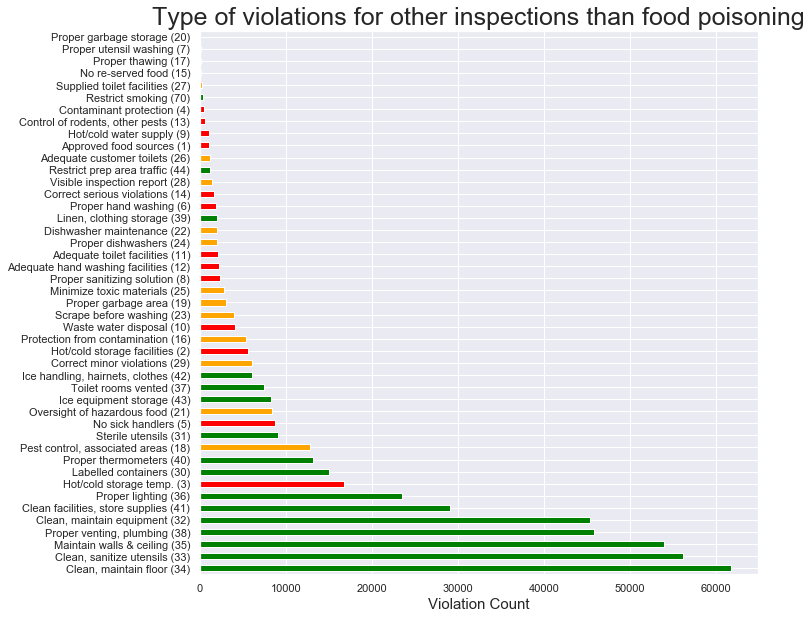

In [64]:
# plotting

# sort sums and colors by sum value
sum_data_other = pd.DataFrame({"sums": sums_other, "colors": colors}).sort_values("sums")

# Plot bar chart
plt.rcParams['figure.figsize'] = (10, 10)
ax = sum_data_other.sums.plot(kind = "barh", color = sum_data_other.colors)
ax.set_title("Type of violations for other inspections than food poisoning", fontsize = 25)
ax.set_xlabel("Violation Count", fontsize = 15)
ax.invert_yaxis()
plt.show()

**Observations:** Here again, the major critical violation is *hot/cold storage temperature*. We need to investigate which violations are present in the inspection due to suspected poisoning in a higher proportion than for other inspections.

> We need to calculate again the frequency of each violation per other kind of inspection.

In [65]:
# total number of violations within the other inspections dataframe
violation_number = sum_data_other['sums'].sum()

# proportion of each violation
sum_data_other['frequency'] = sum_data_other['sums'].divide(violation_number)*100
sum_data_other = sum_data_other.sort_values('frequency', ascending = False)

print('\n\033[1m Violations for other inspection than food poisoning \033[0m')
display(sum_data_other)


 Violations for other inspection than food poisoning 


,sums,colors,frequency
"Clean, maintain floor (34)",61736.0,green,12.948068
"Clean, sanitize utensils (33)",56148.0,green,11.776081
Maintain walls & ceiling (35),53930.0,green,11.310893
"Proper venting, plumbing (38)",45808.0,green,9.607443
"Clean, maintain equipment (32)",45334.0,green,9.508030
"Clean facilities, store supplies (41)",29123.0,green,6.108050
Proper lighting (36),23532.0,green,4.935434
Hot/cold storage temp. (3),16728.0,red,3.508411
Labelled containers (30),14984.0,green,3.142637
Proper thermometers (40),13167.0,green,2.761553


## Comparison between case 1 and case 2

In [66]:
# we merge to previous dataframe to compare the frequency
comparison = pd.merge(sum_data, sum_data_other, left_index = True, right_index = True, suffixes = ('_poisoning','_others')).sort_values('frequency_poisoning', ascending = False).reset_index()
del comparison['colors_others']

# associate a number to each value of the feature
work_mapper = {'red':'critical','orange':'severe','green':'minor'}

# replace them in the dataframe
comparison['colors_poisoning'] = comparison['colors_poisoning'].replace(work_mapper)
comparison.rename(columns = {'colors_poisoning': 'violation_type','index':'violations'}, inplace = True)

> In the next step, we will create a dataframe with the violations present in high frequency in the inspection due to food poisoning suspection compared to other inspections.We also calculate a ratio wich quantify how much higher the frequency is in the poisoning case compared to the other.

In [69]:
high_risk = comparison[comparison['frequency_poisoning'] > comparison['frequency_others']]
high_risk['ratio'] = high_risk['frequency_poisoning'].divide(high_risk['frequency_others'])
high_risk.sort_values('ratio', ascending = False)

,violations,sums_poisoning,violation_type,frequency_poisoning,sums_others,frequency_others,ratio
30,Contaminant protection (4),18.0,critical,0.475813,469.0,0.098365,4.837231
39,No re-served food (15),5.0,critical,0.132170,138.0,0.028943,4.566549
18,Proper hand washing (6),49.0,critical,1.295268,1845.0,0.386957,3.347317
41,Proper garbage storage (20),2.0,severe,0.052868,82.0,0.017198,3.074067
21,Proper sanitizing solution (8),39.0,critical,1.030928,2331.0,0.488887,2.108723
42,Proper utensil washing (7),2.0,critical,0.052868,120.0,0.025168,2.100612
38,Restrict smoking (70),6.0,minor,0.158604,379.0,0.079489,1.995305
40,Proper thawing (17),2.0,severe,0.052868,135.0,0.028314,1.867211
12,Protection from contamination (16),75.0,severe,1.982554,5369.0,1.126056,1.760618
5,Hot/cold storage temp. (3),231.0,critical,6.106265,16728.0,3.508411,1.740464


**Observations :** Some violations are 4 time more frequent in the case of inspection due to suspected food poisoning. Plus, the 3 more frequent violations compared to the others inspections are critical. Thus, we can emit the hypothesis that we can predict a food poisoning based on the kind of violations noticed during an inspection. 

**Future Work:**
- Illustrate the previous result with a convenient visualization.
- Add statistical results.

# PART III : Applied Machine Learning

We want to investigate if we can predict food poisoning. To do so, we will use applied machine learning. 

In [70]:
#Import specific packages for machine learning

from sklearn.model_selection import train_test_split, validation_curve, cross_val_score, KFold
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

## ML models for classifiation

> We decided to go for a classification model, since the variables that we want to predict (type of inspection and result) take limited discrete values (e.g. Fail, Pass, Pass w/ Conditions for the variable 'results').

> We tested different classification models in order to obtain the best accuracy. First, we need to optimize the Hyper-Parameter of each model, before computing the performance of the tuned model on the test set. Since these algorithms are going to be used several times, we created functions for the respective optimization and performance testing of each model.

### Ridge Classification 

In [71]:
def Ridge_classification_optimization(X_train, y_train):
    '''
    Optimize the regularization parameter 𝛼 of the Ridge classification model.
    
    Parameters
    -----------
    X_train, y_train: pandas.DataFrame
    
    Returns
    --------
    best_param_val_r: int
        The optimal 𝛼
    '''

    seed=0

    # Define a random classifier pipeline
    estimators = []
    estimators.append(('standardize', StandardScaler()))
    estimators.append(('ridge_clf', RidgeClassifier()))
    ridge_pipe = Pipeline(estimators)

    # We use the accuracy obtained on the cross validation folds as a metric
    score = 'accuracy'
    n_splits = 3

    # Set up the cross-validation generator for later use in the 'validation_curve' function
    cv_schema = KFold(n_splits = n_splits, random_state = seed)

    # Tune the model against a single hyper parameter
    tuning_param = 'ridge_clf__alpha'
    tuning_param_range = np.logspace(-4, 5, 10)

    # Compute training and test scores for varying parameter values using 'validation_curve' 
    train_scores_val, cv_scores_val = validation_curve(
        ridge_pipe, X_train, y_train, param_name = tuning_param, param_range = tuning_param_range,
        cv = cv_schema, scoring = score, n_jobs = -1)

    # Obtain the best value of the hyper parameter, and the highest accuracy score
    best_param_val_r = tuning_param_range[np.argmax(np.mean(cv_scores_val, axis=1))]
    best_ridge_acc = max(np.mean(cv_scores_val, axis=1))
    #print('Best alpha : ' + str(best_param_val_r))
    #print('Best ridge accuracy : ' + str(best_ridge_acc))

    return best_param_val_r , ridge_pipe

In [72]:
def Ridge_classification(best_param_val_r, X_train, y_train, X_test, y_test,ridge_pipe):
    '''
    Create the model for ridge classification with the best parameter 𝛼.
    Compute the performance of the tuned model on test set.
    
    Parameters
    -----------
    best_param_val_r: float
        The optimal 𝛼
        
    X_train, y_train, X_test, y_test: pandas.DataFrame
        Training and test sets
    
    Returns
    -------
    null
    '''
    ridge_pipe.set_params(ridge_clf__alpha = best_param_val_r)
    ridge_pipe.fit(X_train,y_train)
    y_pred = ridge_pipe.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    print ('Ridge classifer accuracy = %2.4f' %score)

### Random Forest


In [73]:
def Rf_optimization(X_train, y_train):
    '''
    Optimize the regularization parameter of the Random Forest classification model.
    
    Parameters
    -----------
    X_train, y_train: pandas.DataFrame
    
    Returns
    --------
    best_param_val_rf: int
        The optimal n_estimators
    '''
    seed = 1

    # Define a random classifier pipeline
    estimators = []
    estimators.append(('rf_clf', RandomForestClassifier()))
    pipeline = Pipeline(estimators)

    # Fixed parameters
    score = 'accuracy'
    tuning_param_range = [int(i) for i in np.linspace(10, 100, 10)]
    tuning_param = 'rf_clf__n_estimators'
    cv_schema = KFold(n_splits = 5, random_state = seed)

    # Tune hyper parameter using validation curve
    train_scores_val, cv_scores_val = validation_curve(
        pipeline, X_train, y_train, param_name = tuning_param, param_range = tuning_param_range,
        cv = cv_schema, scoring = score, n_jobs = -1)

    # Obtain the best value of the hyper parameter, with the best accuracy score
    best_param_val_rf = tuning_param_range[np.argmax(np.mean(cv_scores_val, axis=1))]
    best_rf_acc = max(np.mean(cv_scores_val, axis=1))

    #print ('best n_estimators = %d with accuracy score = %2.4f' %(best_param_val_rf, best_rf_acc))
    
    return best_param_val_rf,pipeline

In [74]:
def Rf_classification(best_param_val_rf, X_train, y_train, X_test, y_test,pipeline):
    '''
    Create the model for Random Forest classification with the best parameter value.
    Compute the performance of the tuned model on the test set.
    
    Parameters
    -----------
    best_param_val_rf: int
        The best parameter value
        
    X_train, y_train, X_test, y_test: pandas.DataFrame
        Training and test sets
    
    Returns
    -------
    null
    '''
    pipeline.set_params(rf_clf__n_estimators = best_param_val_rf)
    pipeline.fit(X_train,y_train)
    y_pred = pipeline.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    print ('rf classifer accuracy = %2.4f' %score)

### Gradient Boosted Trees

In [76]:
def GBT_optimization(X_train, y_train):
    '''
    Optimize the regularization parameter of the Gradient Boosted Trees classification model.
    
    Parameters
    -----------
    X_train, y_train: pandas.DataFrame
    
    Returns
    --------
    best_param_val_GBT: int
        The optimal Hyper-parameter
    '''

    estimators = []
    estimators.append(('XGB_clf', XGBClassifier()))
    gb_pipe = Pipeline(estimators)

    # Fixed parameters
    score = 'accuracy'
    n_splits = 3
    seed=0
    
    # CV schema
    cv_schema = KFold(n_splits = n_splits, random_state = seed)

    # Tune model against a single hyper parameter
    tuning_param = 'XGB_clf__n_estimators'
    tuning_param_range = [int(i) for i in np.linspace(10.0, 30.0, 5)]

    # Tune hyper parameter using validation curve
    train_scores_val, cv_scores_val = validation_curve(
        gb_pipe, X_train, y_train, param_name = tuning_param, param_range = tuning_param_range,
        cv = cv_schema, scoring = score, n_jobs = -1)

    # Obtain the best value of the hyper parameter
    best_param_val_GBT = tuning_param_range[np.argmax(np.mean(cv_scores_val, axis=1))]
    best_xgb_acc = max(np.mean(cv_scores_val, axis=1))
    #print(best_param_val_GBT)
    #print(best_xgb_acc)
    
    return best_param_val_GBT 

In [77]:
def GBT_classification(best_param_val_GBT, X_train, y_train, X_test, y_test):
    '''
    Create the model for Gradient Boosted Trees classification with the best parameter value.
    Compute the performance of the tuned model on the test set.
    
    Parameters
    -----------
    best_param_val_GBT: int
        The best parameter value
        
    X_train, y_train, X_test, y_test: pandas.DataFrame
        Training and test sets
    
    Returns
    -------
    null
    '''
    optimal_xgb =  XGBClassifier(n_estimators=best_param_val_GBT)
    optimal_xgb.fit(X_train,y_train)
    xgb_pred = optimal_xgb.predict(X_test)
    acc_xgb = accuracy_score(y_test, xgb_pred)

    print("Gradient Boosted trees model score : " + str(acc_xgb))

### 1-  Inspection results prediction 

> In this section, we provide a proof of concept for a machine learning model that can predict the inspection outcome (result) for a given food facility.

#### Preprocessing

> The features that we decided to use are the following; we can safely discard the rest of the columns.

In [81]:
#features and target variable
restaurant_data = ['results', 'inspection_type',
       'violations_count', 'zip', 'risk', 'critical_count',
       'serious_count', 'minor_count']

In [82]:
df_01 = violations_dataframe[restaurant_data]
df_01.head()

,results,inspection_type,violations_count,zip,risk,critical_count,serious_count,minor_count
0,Pass,Canvass Re-Inspection,0.0,60630,Risk 1 (High),0.000000,0.0,0.000000
1,Pass w/ Conditions,Canvass Re-Inspection,2.0,60632,Risk 2 (Medium),1.000000,0.0,0.000000
2,Fail,Canvass,3.0,60652,Risk 1 (High),0.666667,0.0,0.333333
3,Pass w/ Conditions,Canvass,0.0,60623,Risk 1 (High),0.000000,0.0,0.000000
4,Pass w/ Conditions,Canvass,1.0,60625,Risk 1 (High),1.000000,0.0,0.000000


> Since our final goal will be to train a linear machine learning model, all of the features we use need to be numerical. Some features like the 'inspection_type' and 'risk' are non-numeric and non-atomic. We transform these features into numerical features. As the risk feature is ordinal (from low to high), we choose to encode it accordingly instead of using one hot encoding (get_dummies). We do the same for the inspection result.

In [84]:
# Associate a number to each value of the risk factor
risk_mapper = {'Risk 1 (High)':3,'Risk 2 (Medium)':2,'Risk 3 (Low)':1}

# Associate a number to each value of the results
result_mapper = {'Pass':1,'Pass w/ Conditions':0,'Fail':-1}

# Replace them in the dataframe
df_01['risk'] = df_01['risk'].replace(risk_mapper).astype(int)
df_01['results'] = df_01['results'].replace(result_mapper).astype(int)

df_01.head()

,results,inspection_type,violations_count,zip,risk,critical_count,serious_count,minor_count
0,1,Canvass Re-Inspection,0.0,60630,3,0.000000,0.0,0.000000
1,0,Canvass Re-Inspection,2.0,60632,2,1.000000,0.0,0.000000
2,-1,Canvass,3.0,60652,3,0.666667,0.0,0.333333
3,0,Canvass,0.0,60623,3,0.000000,0.0,0.000000
4,0,Canvass,1.0,60625,3,1.000000,0.0,0.000000


> We encode the other features using 'hot encoding' or get_dummies.

In [86]:
# Hot encoding of the 'zip' and 'inspection_type' features
df_01 = pd.get_dummies(df_01, columns = ['inspection_type', 'zip'])

df_01.head()

,results,violations_count,risk,critical_count,serious_count,minor_count,inspection_type_Canvass,inspection_type_Canvass Re-Inspection,inspection_type_Complaint,inspection_type_Complaint Re-Inspection,...,zip_60655,zip_60656,zip_60657,zip_60659,zip_60660,zip_60661,zip_60666,zip_60707,zip_60827,zip_nan
0,1,0.0,3,0.000000,0.0,0.000000,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,2.0,2,1.000000,0.0,0.000000,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,-1,3.0,3,0.666667,0.0,0.333333,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0.0,3,0.000000,0.0,0.000000,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1.0,3,1.000000,0.0,0.000000,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


> Then, we build both the target dataframe (variable to predict) and the features dataframe.

In [87]:
# Make the features and target dataframes and display the features dataframe
target_df_01 = df_01.results
features_df_01 = df_01.drop(['results'], axis = 1)

features_df_01.head()

,violations_count,risk,critical_count,serious_count,minor_count,inspection_type_Canvass,inspection_type_Canvass Re-Inspection,inspection_type_Complaint,inspection_type_Complaint Re-Inspection,inspection_type_Short Form Complaint,...,zip_60655,zip_60656,zip_60657,zip_60659,zip_60660,zip_60661,zip_60666,zip_60707,zip_60827,zip_nan
0,0.0,3,0.000000,0.0,0.000000,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2.0,2,1.000000,0.0,0.000000,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3.0,3,0.666667,0.0,0.333333,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.0,3,0.000000,0.0,0.000000,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1.0,3,1.000000,0.0,0.000000,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


> Now, we split the data randomly into a train (80%) and a test set (20%), using 1 as the random seed. 

In [89]:
X_train_01, X_test_01, y_train_01, y_test_01 = train_test_split(features_df_01, target_df_01, test_size = 0.2, random_state = 1)

> Next, we optimize the different models according to their corresponding Hyper-parameters, and compute their accuracy on the test set.

#### Model application 

In [90]:
# Ridge classification:

# Optimization of the hyperparameter alpha
best_param_val_r_01,ridgepipe = Ridge_classification_optimization(X_train_01, y_train_01)

# Build the model with the best parameter and test it on the test set.
Ridge_classification(best_param_val_r_01, X_train_01, y_train_01, X_test_01, y_test_01,ridgepipe)

Ridge classifer accuracy = 0.8198


In [91]:
# Random Forest classification:

# Optimization of the hyperparameter 
best_param_val_rf_01,pipeline_rf = Rf_optimization(X_train_01, y_train_01)

# Build the model with the best parameter and compute its accuracy on the test set.
Rf_classification(best_param_val_rf_01, X_train_01, y_train_01, X_test_01, y_test_01,pipeline_rf)

rf classifer accuracy = 0.8827


In [94]:
# Gradient Boosted Trees classification:

# Optimization of the hyperparameter 
best_param_val_GBT_01 = GBT_optimization(X_train_01, y_train_01)

# Build the model with the best parameter and compute its accuracy on the test set.
GBT_classification(best_param_val_GBT_01, X_train_01, y_train_01, X_test_01, y_test_01)

Gradient Boosted trees model score : 0.8868036937742032


**Conclusions**: The model that gave the higher accuracy (~0.89) for the set of features used is the Gradient Boosted Trees. However, this accuracy is extremely high. We need to investigate more about this results for the next milestone. 

### 2) Predecting the inspection type from the violations

> Here, we demonstrate the feasibility of a machine learning model that can predict the inspection type (e.g. poisoning), given the result of the inspection and the different commited violations in particular, for a given food facility.

#### Preprocessing

> For each inspection shown below, we retrieved and encoded with a binary value the different violations committed during that inspection.

In [95]:
violations_df.head()

,#1,#2,#3,#4,#5,#6,#7,#8,#9,#10,...,#42,#43,#44,#70,inspection_id,license,inspection_type,zip,risk,results
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2346127,2637127.0,Canvass Re-Inspection,60630,Risk 1 (High),Pass
1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2346126,2432147.0,Canvass Re-Inspection,60632,Risk 2 (Medium),Pass w/ Conditions
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,2346149,2215652.0,Canvass,60652,Risk 1 (High),Fail
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2346103,2215467.0,Canvass,60623,Risk 1 (High),Pass w/ Conditions
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2346063,2215787.0,Canvass,60625,Risk 1 (High),Pass w/ Conditions


> As usual, we select the features and target variable from the dataframe, and turn categorical data into numerical features. 

In [96]:
# Drop the unacessary columns
df_02 = violations_df.drop(['inspection_id', 'license'], axis = 1)

# Turn 'risk' and 'results' into ordinal numerical features
df_02['risk'] = df_02['risk'].replace(risk_mapper).astype(int)
df_02['results'] = df_02['results'].replace(result_mapper).astype(int)

# Hot encoding for the feature 'zip'
df_02 = pd.get_dummies(df_02, columns = ['zip'])

df_02.head()

,#1,#2,#3,#4,#5,#6,#7,#8,#9,#10,...,zip_60655,zip_60656,zip_60657,zip_60659,zip_60660,zip_60661,zip_60666,zip_60707,zip_60827,zip_nan
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


> Next, we need to transform the target categorical variable ('inspection_type') into a numerical variable in order to use it in our model.

In [97]:
# Check the different types of inspections
df_02['inspection_type'].unique()

array(['Canvass Re-Inspection', 'Canvass', 'Complaint',
       'Short Form Complaint', 'Complaint Re-Inspection',
       'Suspected Food Poisoning',
       'Suspected Food Poisoning Re-inspection'], dtype=object)

In [98]:
# Turn categorical target into numerical target
inspection_mapper = {'Canvass':1,'Complaint':2, 'Canvass Re-Inspection':3,
       'Short Form Complaint':4, 'Suspected Food Poisoning':5,
       'Complaint Re-Inspection':6,
       'Suspected Food Poisoning Re-inspection':7}

# Replace it in the dataframe
df_02['inspection_type'] = df_02['inspection_type'].replace(inspection_mapper).astype(int)

df_02.head()

,#1,#2,#3,#4,#5,#6,#7,#8,#9,#10,...,zip_60655,zip_60656,zip_60657,zip_60659,zip_60660,zip_60661,zip_60666,zip_60707,zip_60827,zip_nan
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [99]:
# Check for the conversion
df_02['inspection_type'].unique()

array([3, 1, 2, 4, 6, 5, 7])

> Then, we build the features and target dataframes.

In [100]:
# Make the features and target dataframes and display the features dataframe
target_df_02 = df_02.inspection_type
features_df_02 = df_02.drop(['inspection_type'], axis = 1)

features_df_02.head()

,#1,#2,#3,#4,#5,#6,#7,#8,#9,#10,...,zip_60655,zip_60656,zip_60657,zip_60659,zip_60660,zip_60661,zip_60666,zip_60707,zip_60827,zip_nan
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


> Now, we split the data randomly into a train (80%) and a test set (20%), using 1 as the random seed. Next, we optimize the different models according to their corresponding Hyper-parameters, and compute their accuracy on the test set.

In [101]:
# Split into train and test sets
X_train_02, X_test_02, y_train_02, y_test_02 = train_test_split(features_df_02, target_df_02, test_size = 0.2, random_state = 1)

#### Model Application

In [102]:
# Ridge classification:

# Optimization of the hyperparameter alpha
best_param_val_r_02,ridgepipe_02 = Ridge_classification_optimization(X_train_02, y_train_02)

# Build the model with the best parameter and test it on the test set.
Ridge_classification(best_param_val_r_02, X_train_02, y_train_02, X_test_02, y_test_02,ridgepipe_02)

Ridge classifer accuracy = 0.6157


In [103]:
# Random Forest classification:

# Optimization of the hyperparameter 
best_param_val_rf_02,ridgepipe_rf_02 = Rf_optimization(X_train_02, y_train_02)

# Build the model with the best parameter and compute its accuracy on the test set.
Rf_classification(best_param_val_rf_02, X_train_02, y_train_02, X_test_02, y_test_02,ridgepipe_rf_02)

rf classifer accuracy = 0.6110


In [107]:
# Gradient Boosted Trees classification:

# Optimization of the hyperparameter 
best_param_val_GBT_02 = GBT_optimization(X_train_02, y_train_02)

# Build the model with the best parameter and compute its accuracy on the test set.
GBT_classification(best_param_val_GBT_02, X_train_02, y_train_02, X_test_02, y_test_02)

Gradient Boosted trees model score : 0.6159517426273459


**Conclusions**: The classification accuracy is quite low overall. This means that our models will predict the correct inspection type (e.g. the poisoning cases) with an accuracy of ~61%. We want to do better for the future and we believe that this could be achieved by a better preprocessing (e.g. better feature selection) of the data.

### 3) Predicting inspection due to food poisoning


> In this part, we focus only on predicting the inspection due to food poisoning . If it is the case , then we can predict if the food facility is not safe based on other inspections type.

#### Preprocessing

> The only difference from the task above is that we will encode the inspection type as follow : 
- 1 for inspection due to suspected food poisoning
- 0 for the others ( canvas, complains and  re-inspections)

In [108]:
df_03 = violations_df.drop(['inspection_id', 'license'], axis = 1)

df_03.head()

,#1,#2,#3,#4,#5,#6,#7,#8,#9,#10,...,#40,#41,#42,#43,#44,#70,inspection_type,zip,risk,results
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,Canvass Re-Inspection,60630,Risk 1 (High),Pass
1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,Canvass Re-Inspection,60632,Risk 2 (Medium),Pass w/ Conditions
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,Canvass,60652,Risk 1 (High),Fail
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,Canvass,60623,Risk 1 (High),Pass w/ Conditions
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,Canvass,60625,Risk 1 (High),Pass w/ Conditions


In [109]:
# Associate a number to each value of the risk factor
risk_mapper = {'Risk 1 (High)':3,'Risk 2 (Medium)':2,'Risk 3 (Low)':1}

# Associate a number to each value of the results
result_mapper = {'Pass':1,'Pass w/ Conditions':0,'Fail':-1}

#associate a binary value in function of the inspection type
inspection_mapper = {'Canvass Re-Inspection':0,'Canvass':0,'Complaint':0,'Complaint Re-Inspection':0,'Suspected Food Poisoning Re-inspection':0,'Short Form Complaint':0,'Suspected Food Poisoning':1}

# Replace them in the dataframe
df_03['risk'] = df_03['risk'].replace(risk_mapper).astype(int)
df_03['results'] = df_03['results'].replace(result_mapper).astype(int)
df_03['inspection_type'] = df_03['inspection_type'].replace(inspection_mapper).astype(int)

df_03.head()

,#1,#2,#3,#4,#5,#6,#7,#8,#9,#10,...,#40,#41,#42,#43,#44,#70,inspection_type,zip,risk,results
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,60630,3,1
1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,60632,2,0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,60652,3,-1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,60623,3,0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,60625,3,0


In [110]:
# Check for the conversion
df_03['inspection_type'].unique()

array([0, 1])

In [111]:
# Hot encoding for the feature 'zip'
df_03 = pd.get_dummies(df_03, columns = ['zip'])

In [112]:
# Make the features and target dataframes and display the features dataframe
target_df_03 = df_03.inspection_type
features_df_03 = df_03.drop(['inspection_type'], axis = 1)

features_df_03.head()

,#1,#2,#3,#4,#5,#6,#7,#8,#9,#10,...,zip_60655,zip_60656,zip_60657,zip_60659,zip_60660,zip_60661,zip_60666,zip_60707,zip_60827,zip_nan
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [113]:
X_train_03, X_test_03, y_train_03, y_test_03 = train_test_split(features_df_03, target_df_03, test_size = 0.2, random_state = 1)

#### Model Application 

In [114]:
# Ridge classification:

# Optimization of the hyperparameter alpha
best_param_val_r_03,ridgepipe_03 = Ridge_classification_optimization(X_train_03, y_train_03)

# Build the model with the best parameter and test it on the test set.
Ridge_classification(best_param_val_r_03, X_train_03, y_train_03, X_test_03, y_test_03,ridgepipe_03)

Ridge classifer accuracy = 0.9933


In [115]:
# Random Forest classification:

# Optimization of the hyperparameter 
best_param_val_rf_03,ridgepipe_rf_03 = Rf_optimization(X_train_03, y_train_03)

# Build the model with the best parameter and compute its accuracy on the test set.
Rf_classification(best_param_val_rf_03, X_train_03, y_train_03, X_test_03, y_test_03,ridgepipe_rf_03)

rf classifer accuracy = 0.9927


In [116]:
# Gradient Boosted Trees classification:

# Optimization of the hyperparameter 
best_param_val_GBT_03 = GBT_optimization(X_train_03, y_train_03)

# Build the model with the best parameter and compute its accuracy on the test set.
GBT_classification(best_param_val_GBT_03, X_train_03, y_train_03, X_test_03, y_test_03)

Gradient Boosted trees model score : 0.9932975871313673


**Conclusions:** By changing the way we encoded the *inspection_type* , we could predict in a more accurate way the inspection due to suspected food poisoning. But it seems that this accuracy is to high to be real. This is probably due to overfitting , but we need to investigate more about it. 

**Future Work :** 
- Investigate more about the accuracy value which seems to be very high (overfitting?). Try to overcome this issue by improving our model.
- Find statistical coefficient for the features used to predict the inspection due to food poisoning.
- Create a score using weights reflecting the stastistical coefficients . The aim of such a score is to evaluate food safety within a facility based on the inspection made by staff from the Chicago Department of Public Health’s Food Protection Program using a standardized procedure. Using this score , we can try to prevent food poisoning based on the outcome of other investigations as canvas , complaint... 
- Finaly, we can test the workability of our score based on real poisoning complaint from [I was poisoned](https://iwaspoisoned.com/location/united-states/illinois/chicago#botpress).